In [68]:
## PART 3 - SEAM CARVING - SINTESIS D'IMATGES.
%matplotlib inline

In [69]:
# carreguem totes les llibreries necesaries per a la practica
from skimage import data, draw, color, data, restoration, filters,transform, util
from scipy import misc, fftpack, signal
from scipy.misc import imresize
from scipy import ndimage as nd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
import scipy

In [70]:
#normalitzacio d'imatge
def norm(img):
    return np.real((img - np.min(img)) * 256 / (np.max(img) - np.min(img)))

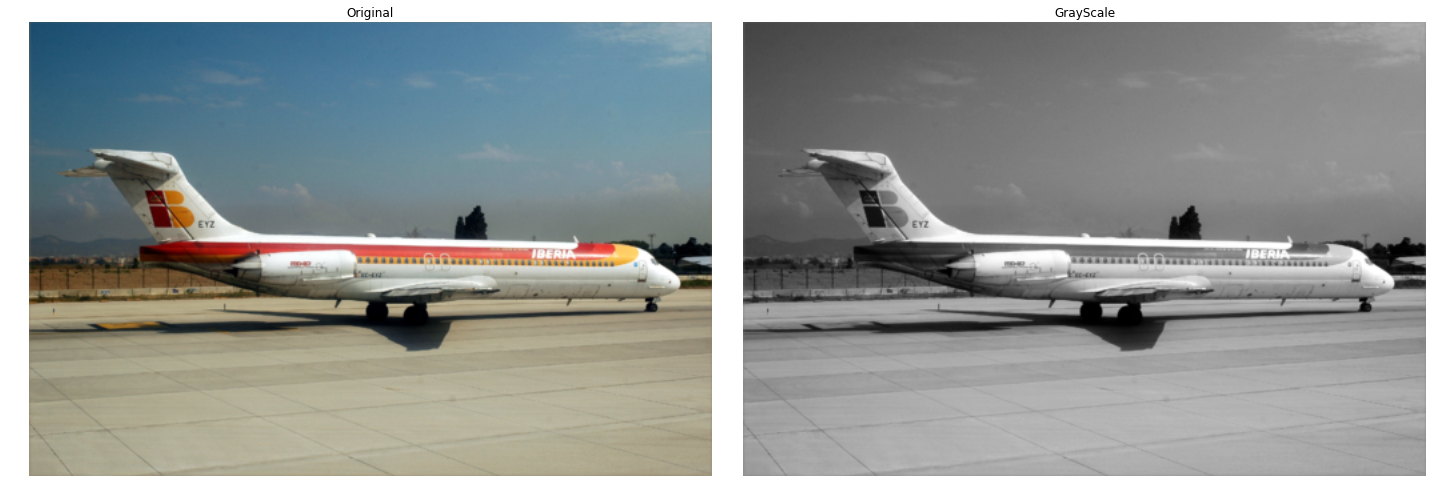

In [71]:
RGB = plt.imread('iberia.jpg')
scale_factor=2
RGB = imresize(RGB, ( RGB.shape[0]/scale_factor, RGB.shape[1]/scale_factor,3),interp='bilinear').astype('float')
img = color.rgb2gray(RGB)

#Visualization
fig = plt.figure(1) 
plt.subplot(1,2,1)
plt.imshow(RGB.astype('uint8'))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(norm(img), cmap="gray")
plt.title('GrayScale')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()

In [72]:
# Funcio que trobara els gradients de l'imatge
#def gradient(img):
    #img = color.rgb2gray(img)
#    gx, gy = np.gradient(img)
#    grad = np.sqrt(gx*gx + gy*gy)
#    return grad

# Calculem el gradient i mostrem el gradient de l'imatge
#grad = gradient(img)
#fig = plt.figure(2) 
#plt.title('Contorns imatge')
#plt.imshow(grad, cmap="gray" )
#plt.show()

In [73]:
# * * * * * * * * * * * * * * *
# * Gradient Magnitude Matrix *
# * * * * * * * * * * * * * * *
def gradient(img):
    '''
    compute image gradient magnitude matrix.
    '''
    gx, gy = np.gradient(img)
    grad = np.sqrt(gx*gx + gy*gy)
    return grad

# * * * * * * * * *
# * Energy Matrix *
# * * * * * * * * *
def compute_energy(im):
    '''
    This implements the dynamic programming seam-find algorithm. For an m*n picture, this algorithm
     takes O(m*n) time 
    '''
    im_width, im_height = im.shape
    cost = np.zeros(im.shape)
    cost[0] = im[0] #first row for energy matrix as the original gradient magnitude
  
    for x in range(1, im_width):
        for y in range(im_height):
            if y == 0:
                min_val = min( cost[x-1, y], cost[x-1, y+1] )
            elif y < im_height - 2:
                min_val = min( cost[x-1, y], cost[x-1, y+1] )
                min_val = min( min_val, cost[x-1, y-1] )
            else:
                min_val = min( cost[x-1, y], cost[x-1, y-1] )
            cost[x,y] = im[x,y] + min_val
    return cost

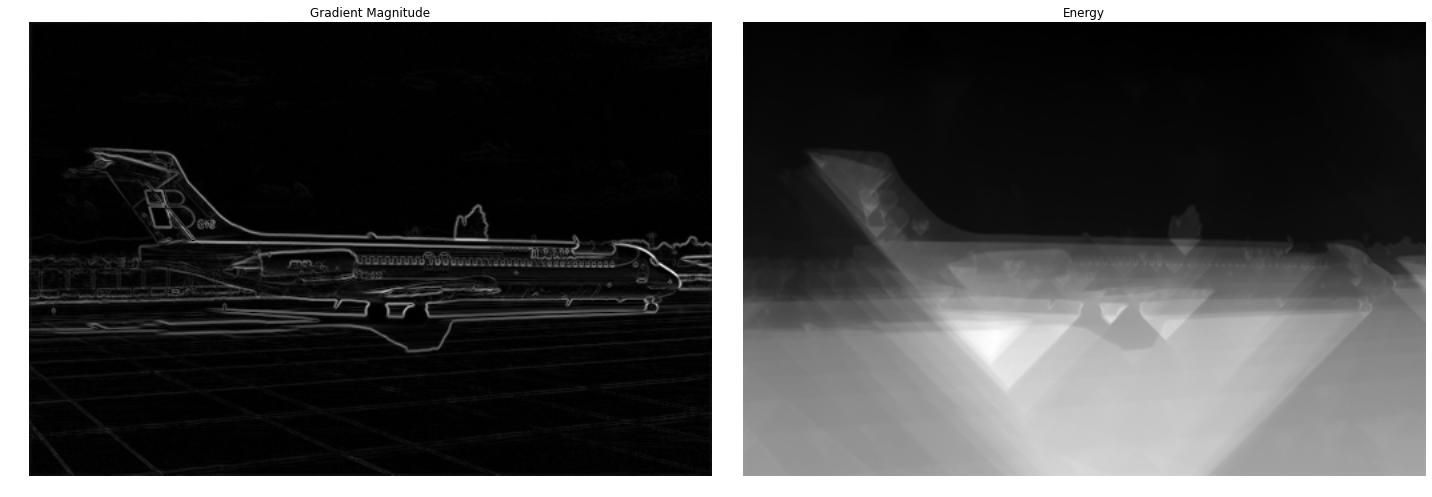

In [74]:
grad = gradient(img)
energy = compute_energy(grad)

#Visualization
fig = plt.figure(2) 
plt.subplot(1,2,1)
plt.imshow(norm(grad), cmap="gray")
plt.title('Gradient Magnitude')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(norm(energy), cmap="gray" )
plt.title('Energy')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()

In [75]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels



In [76]:
def find_vertical_seams(im, it):
    '''
    Takes a grayscale img and returns a list of the @it lowest energy vertical seams as a list of pixels (2-tuples). 
    This implements the dynamic programming seam-find algorithm. For an m*n picture, this algorithm
    takes O(m*n) time 
    @im: a grayscale image
    @it: iterations to do as number of seams to get
    '''
    assert len(im.shape) == 2
    
    im_width, im_height = im.shape
    cost = compute_energy(gradient(im))
    
    paths = []
    visited = []
    
    for i in xrange(it):
        min_val = 1e1000
        path = []
        
        #Get the min value from last energy row not visited yet.
        for y in xrange(im_height):
            if cost[im_width-1,y] < min_val and y not in visited :
                min_val = cost[im_width-1,y]
                min_ptr = y
        #we will take the start path index and save it to avoid repeating same seam without deleting it.        
        visited.append(min_ptr)
        pos = (im_width-1, min_ptr)
        path.append(pos)
        
        while pos[0] != 0:
            val = cost[pos] - grad[pos]
            x,y = pos
            if y == 0:
                if val == cost[x-1,y+1]:
                    pos = (x-1,y+1) 
                else:
                    pos = (x-1,y)
            elif y <= im_height - 2:
                if val == cost[x-1,y+1]:
                    pos = (x-1,y+1) 
                elif val == cost[x-1,y]:
                    pos = (x-1,y)
                else:
                    pos = (x-1,y-1)
            else:
                if val == cost[x-1,y]:
                    pos = (x-1,y)
                else:
                    pos = (x-1,y-1) 

            path.append(pos)
            #print "Reconstruction Complete."
        
        print "iteration",i,"\tpath @",path[0][1]
        paths.append(path)
  

    return paths


def mark_seam(img, path, mark_as='red'):
    '''
    Marks a seam for easy visual checking
    @img: an input img
    @path: the seam
    @mark_as: color of the path-mark. By default red.
    '''
    assert mark_as in ['red','green','blue','black','white']
    assert len(img.shape) == 3
    
    #print "Marking seam..."
    for pixel in path:
        if mark_as == 'red':
           img[pixel] = (255,0,0)
        elif mark_as == 'green':
            img[pixel] = (0,255,0)
        elif mark_as == 'blue':
            img[pixel] = (0,0,255)
        elif mark_as == 'white':
            img[pixel] = (255,255,255)
        elif mark_as == 'black':
            img[pixel] = (0,0,0)
    #print "Marking Complete."
    
    return img;


def vector_avg(u, v):
    '''
    Returns the component average between each vector
    @u: input vector u
    @v: input vector v
    '''
    w = u.astype('uint16') #change type to avoid overflow 
    for i in range(len(w)):
        w[i] = (w[i] + v[i])/2

    return w.astype('uint8')


def add_vertical_seam(img, path):
    '''
    Adds the pixels in a vertical path from img
    @img: an input img
    @path: pixels to delete in a vertical path
    '''
    #print "Adding Vertical Seam..."
    img_height, img_width = img.shape[:2]
    i = np.zeros((img_height, img_width+1, img.shape[2]))
    
    path_set = set(path)
    seen_set = set()
    
    for x in xrange(img_height):
        for y in xrange(img_width):
            if (x,y) not in path_set and x not in seen_set:
                i[x,y] = img[x,y]
            elif (x,y) in path_set and x not in seen_set:
                i[x,y] = img[x,y]
                seen_set.add(x)
                if y <= img_width - 2:
                    i[x,y+1] = vector_avg(img[x,y], img[x,y+1])
                else:
                    i[x,y+1] = vector_avg(img[x,y], img[x,y-1])
            else:
                i[x,y+1] = img[x,y]

    #print "Addition Complete."
    return i

In [77]:
# * * * * * * * * * * * * * * *
# * Seam Carving Enlargement  *
# * * * * * * * * * * * * * * *
def seam_enlargement(it, rgb):
    '''
    Add recursively seams to RGB.
    @it: 
    @RGB: an input img
    @verbose: 
    '''
    result = rgb.copy();
    seams = []

    gray = color.rgb2gray(rgb)
    paths = find_vertical_seams(gray, it)
    
    for p in paths:
        rgb = mark_seam(rgb, p, 'blue')
        seams.append([plt.imshow(rgb.astype('uint8'))])
        result = add_vertical_seam(result, p)

    return result, seams;


iteration 0 	path @ 56
iteration 1 	path @ 58
iteration 2 	path @ 48
iteration 3 	path @ 59
iteration 4 	path @ 57
iteration 5 	path @ 51
iteration 6 	path @ 52
iteration 7 	path @ 55
iteration 8 	path @ 49
iteration 9 	path @ 54
iteration 10 	path @ 45
iteration 11 	path @ 53
iteration 12 	path @ 60
iteration 13 	path @ 46
iteration 14 	path @ 47
iteration 15 	path @ 42
iteration 16 	path @ 50
iteration 17 	path @ 41
iteration 18 	path @ 40
iteration 19 	path @ 61
iteration 20 	path @ 43
iteration 21 	path @ 44
iteration 22 	path @ 39
iteration 23 	path @ 37
iteration 24 	path @ 34
iteration 25 	path @ 62
iteration 26 	path @ 36
iteration 27 	path @ 38
iteration 28 	path @ 63
iteration 29 	path @ 35
iteration 30 	path @ 64
iteration 31 	path @ 66
iteration 32 	path @ 67
iteration 33 	path @ 65
iteration 34 	path @ 33
iteration 35 	path @ 68
iteration 36 	path @ 104
iteration 37 	path @ 69
iteration 38 	path @ 106
iteration 39 	path @ 105
iteration 40 	path @ 30
iteration 41 	path @ 75

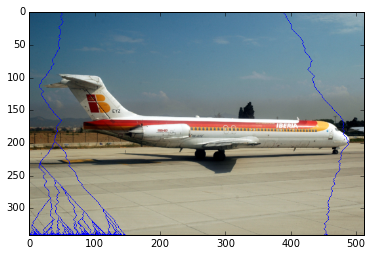

In [78]:
N = 150 # number of seams to be added (as iterations)
fig = plt.figure(3)
result, seams = seam_enlargement(N, RGB.copy());
print result.shape

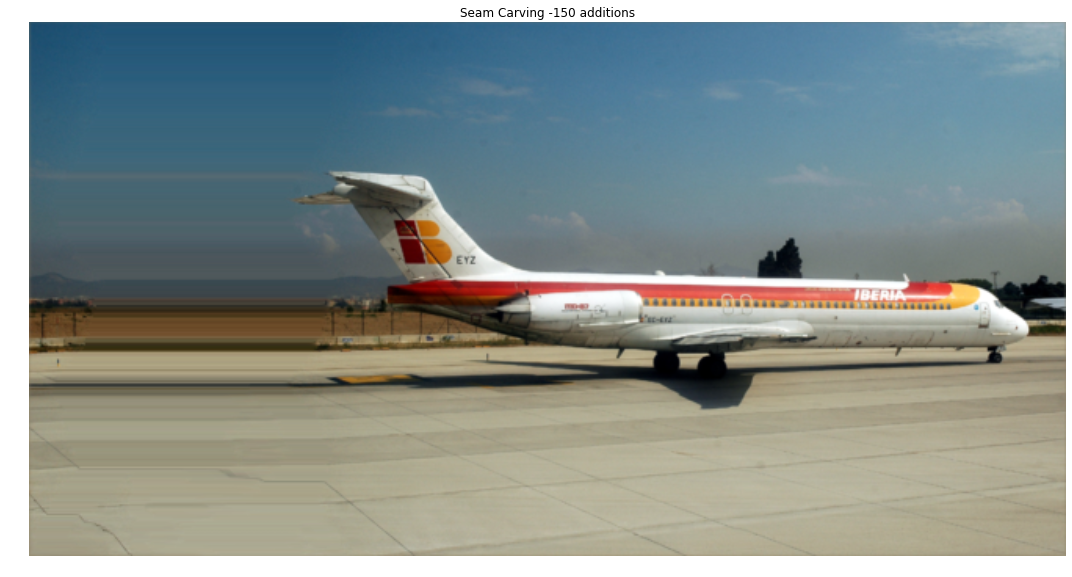

In [79]:
#Visualization
fig = plt.figure(4) 
plt.imshow(result.astype('uint8'))
plt.title('Seam Carving -'+ str(N) + ' additions')
plt.axis('off')
plt.gcf().set_size_inches((15,15))
fig.tight_layout()